# Assignment 2

1. Correlation - numeric. keep cols with good correlation
2. for independent categorical columns and dependent numerical variable, use annova test and check dependency, select these cols and do Target encoding/one hot encoding.
3. normalization - standard scaler, min - max scaler, remove target variable
4. clustering

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as stat
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [3]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [4]:
file_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/cleaned_data.csv"

property_df = pd.read_csv(file_path)
print(property_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   int64  
 1   grosssizeadjusted       5147 non-null   int64  
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   int64  
 4   baths_full              5147 non-null   int64  
 5   bed                     5147 non-null   int64  
 6   rooms_total             5147 non-null   int64  
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   int64  
 10  mktTtlValue             5147 non-null   int64  
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   int64  
 13  property_type           5147 non-null   object 
 14  propsubtype             5147 non-null   

### Analysis on Numerical Columns

In [5]:
num_cols = property_df.columns[property_df.dtypes != 'object']
num_cols

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'saleAmt'], dtype='object')

<AxesSubplot:>

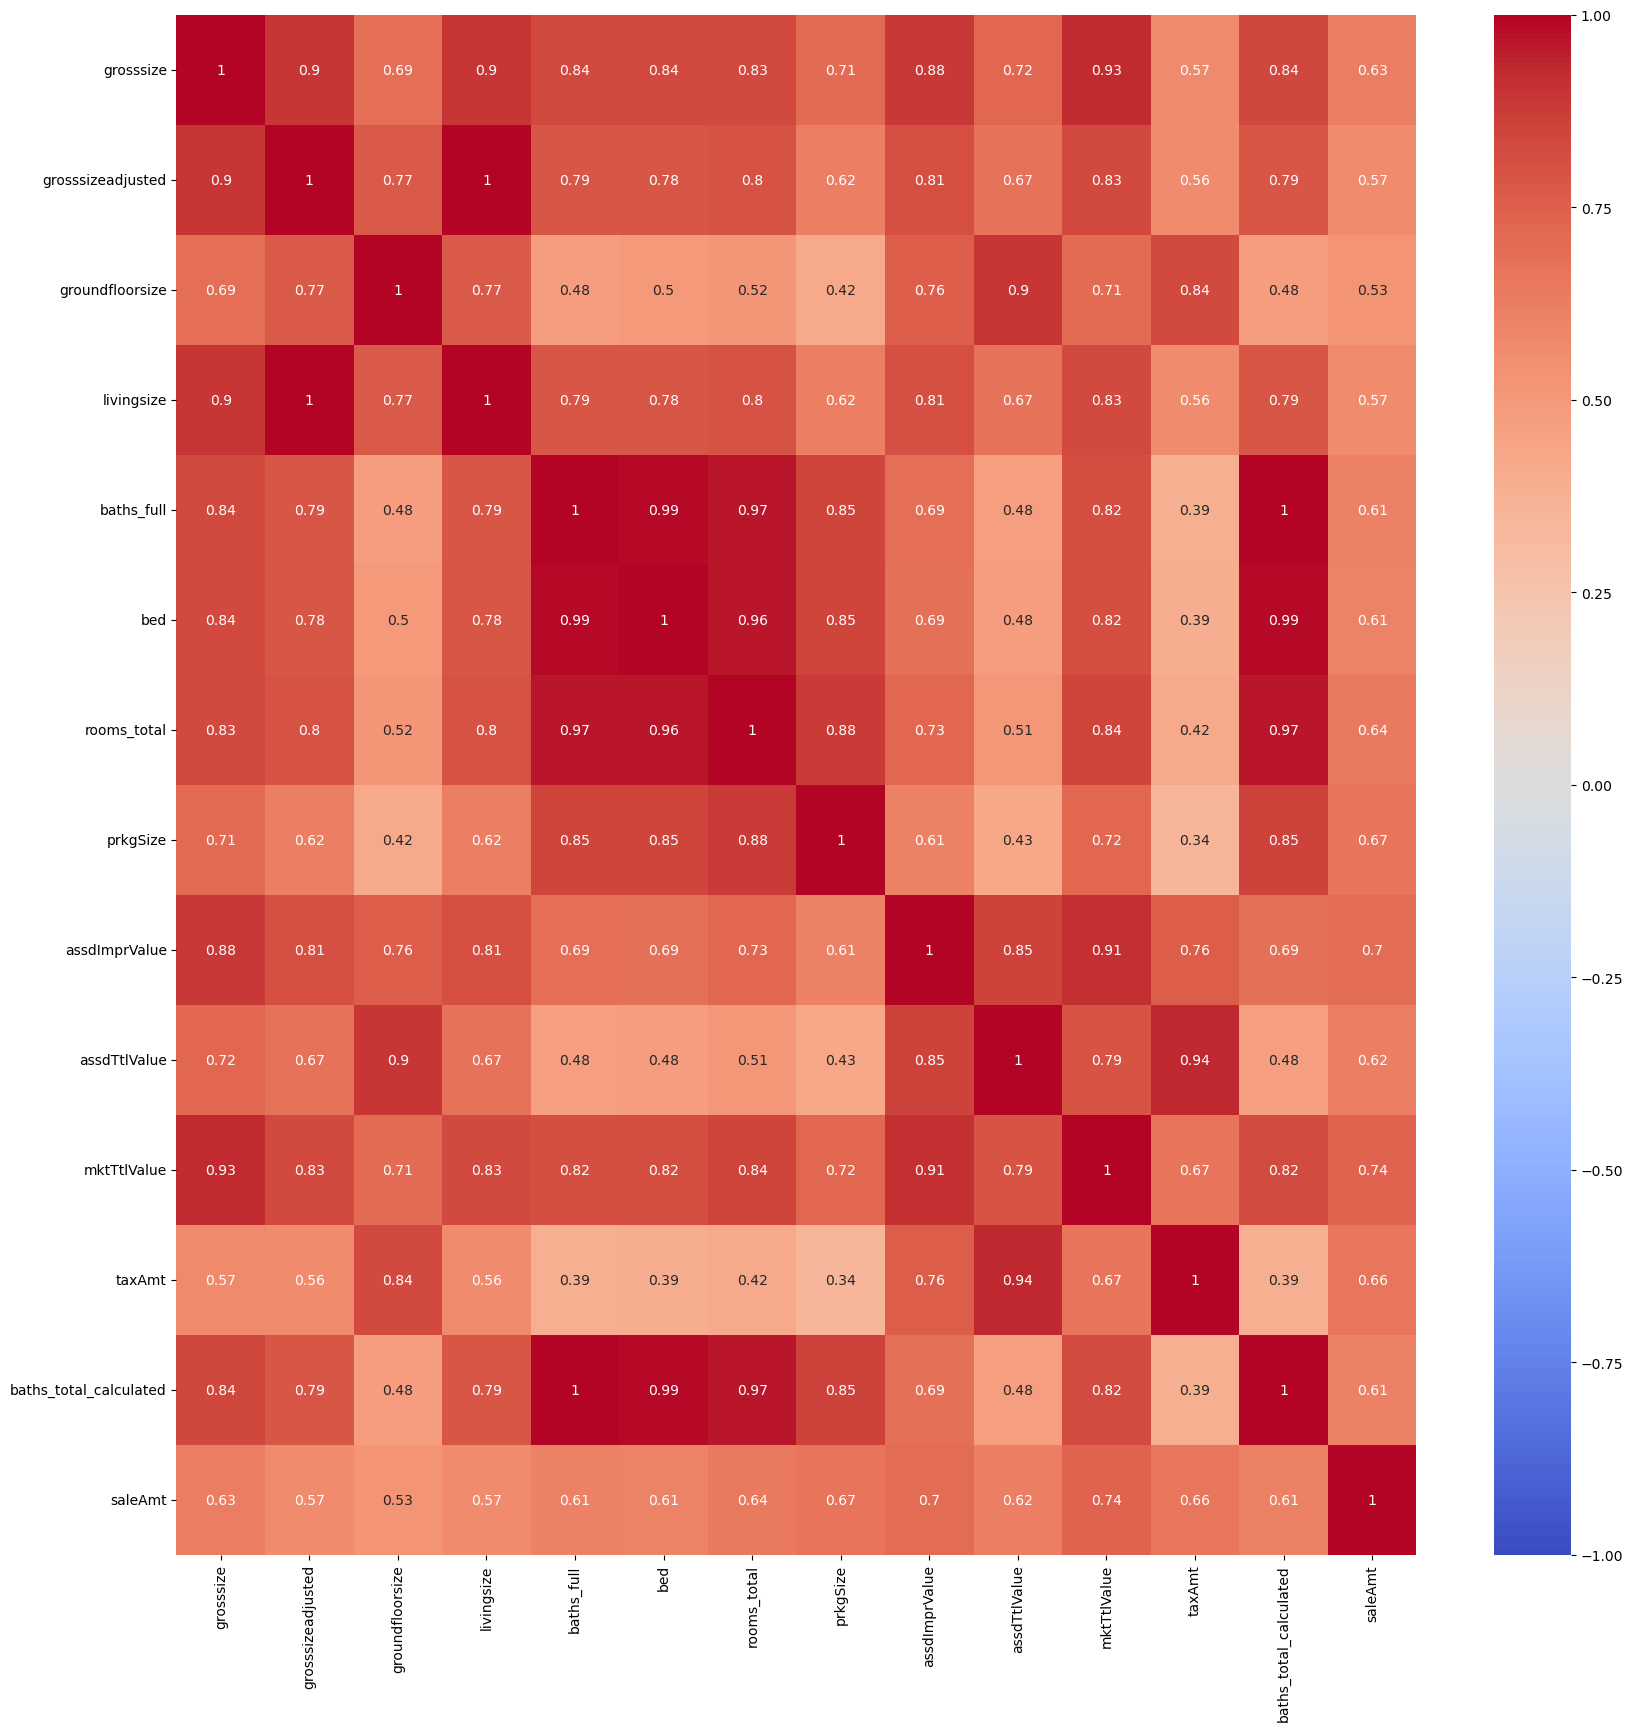

In [6]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### Analysis on Categorical Columns

In [7]:
property_df.describe(include='O')

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
unique,30,7,29,9,6,12,2930,5,11,5,6,4
top,SINGLE FAMILY RESIDENCE,RESIDENTIAL,SFR,FORCED AIR,CENTRAL,BRICK VENEER,3/4/2005,AVERAGE,FRAME,WOOD,"Garage, Attached",CONVENTIONAL HOUSE
freq,2479,4978,2556,4237,2835,2421,33,2674,3195,3267,3361,2981


#### Convert Required Categorical Columns to Numerical Columns for Clustering

In [8]:
data = property_df

# Define a significance level (alpha) for the ANOVA test
alpha = 0.05

# Initialize a list to store columns with significant dependency
significant_cols = []

# Iterate through categorical columns
categorical_columns = data.columns[property_df.dtypes == 'object']
# categorical_columns = ['property_type', 'absenteeInd', 'heatingtype', 'coolingtype', 'wallType', 'saleTransType', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType']

for column in categorical_columns:
    # Perform ANOVA test for independence
    groups = [data[data[column] == category]['saleAmt'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    # Check if the p-value is less than alpha (indicating significant dependency)
    if p_value < alpha:
        significant_cols.append(column)

# Select only the significant columns from the dataset
data_filtered = data[significant_cols + ['saleAmt']]

# Perform target encoding for the selected columns
encoder = ce.TargetEncoder()
data_encoded = encoder.fit_transform(data_filtered.drop('saleAmt', axis=1), data_filtered['saleAmt'])

# Combine the encoded data with the original 'saleAmt' column
property_df_encoded = pd.concat([data_encoded, data_filtered['saleAmt']], axis=1)

property_df_encoded.head(5)

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmt
0,796241.217426,691279.568903,803463.734742,677663.197545,704002.031041,850453.637753,713242.190135,6.061591e+05,685772.730203,741104.830425,603424.419521,2.399808e+06,501930
1,393683.553323,691279.568903,393683.553323,677663.197545,701893.005226,828838.765778,676663.905204,6.061591e+05,685772.730203,741104.830425,786176.916989,6.092664e+05,179350
2,796241.217426,691279.568903,803463.734742,677663.197545,704002.031041,850453.637753,792087.341937,7.907225e+05,685772.730203,741104.830425,786176.916989,7.643636e+05,1900000
3,796241.217426,691279.568903,803463.734742,677663.197545,704002.031041,850453.637753,832184.472070,6.061591e+05,744620.611224,744620.611224,786176.916989,7.643636e+05,1100000
4,796241.217426,691279.568903,803463.734742,677663.197545,704002.031041,850453.637753,751763.406140,1.201011e+06,744620.611224,744620.611224,786176.916989,7.643636e+05,798000


In [9]:
# Drop categorical columns in property_df
property_df = property_df.select_dtypes(exclude=['object'])

# Merge the encoded categorical columns data to property_df
property_df = pd.concat([property_df, property_df_encoded.drop('saleAmt', axis=1)], axis=1)
property_df.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5.147000e+03
mean,2909.412862,1982.077132,1647.700818,1982.077132,2.071304,3.543423,7.492326,495.264846,4.645036e+04,7.128977e+04,8.490291e+05,6541.914312,2.944822,7.448479e+05,6.912288e+05,7.392740e+05,6.912433e+05,7.428788e+05,7.399729e+05,7.379896e+05,7.480519e+05,7.448770e+05,7.309487e+05,7.403743e+05,744761.478359,7.450742e+05
std,8699.439421,5067.840521,4284.518558,5067.840521,13.268863,13.558907,24.028648,1172.644111,1.561694e+05,2.439678e+05,2.115490e+06,21363.092294,13.268904,2.353568e+06,7.706794e+05,2.981515e+05,7.701445e+05,3.012227e+05,2.531116e+05,1.853134e+05,2.866732e+05,2.363256e+05,2.549569e+05,7.295949e+04,118516.285610,2.788011e+05
min,90.000000,90.000000,8.000000,90.000000,0.000000,1.000000,1.000000,86.000000,2.900000e+02,3.430000e+02,1.300000e+03,33.840000,0.000000,5.000000e+02,3.936836e+05,6.912796e+05,3.936836e+05,5.515735e+05,7.018930e+05,5.245341e+05,5.162916e+05,6.061591e+05,6.097213e+05,6.275322e+05,392588.149215,6.092664e+05
25%,1027.500000,970.000000,857.000000,970.000000,1.000000,2.000000,5.000000,260.000000,1.972400e+04,2.889500e+04,4.086000e+05,2713.380000,2.000000,3.290000e+05,3.936836e+05,6.912796e+05,3.936836e+05,6.776632e+05,7.018930e+05,5.245341e+05,6.920765e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,6.092664e+05
50%,1938.000000,1312.000000,1121.000000,1312.000000,1.000000,3.000000,6.000000,480.000000,2.725100e+04,4.545300e+04,6.459000e+05,4257.880000,2.000000,4.980000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.776632e+05,7.040020e+05,8.288388e+05,7.159185e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,7.643636e+05
75%,3214.500000,2006.500000,1592.000000,2006.500000,2.000000,4.000000,8.000000,506.000000,3.926400e+04,6.301250e+04,8.931500e+05,5956.320000,3.000000,7.600000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.776632e+05,7.040020e+05,8.504536e+05,7.502952e+05,7.907225e+05,7.446206e+05,7.446206e+05,786176.916989,7.643636e+05
max,362967.000000,165530.000000,172081.000000,165530.000000,518.000000,518.000000,966.000000,50626.000000,5.077697e+06,1.120128e+07,7.809005e+07,982413.360000,518.000000,1.042500e+08,9.974938e+06,3.182450e+06,9.974938e+06,2.793369e+06,2.599094e+06,2.113130e+06,1.421175e+07,1.968083e+06,3.231621e+06,1.590885e+06,869456.297873,2.399808e+06


In [10]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   int64  
 1   grosssizeadjusted       5147 non-null   int64  
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   int64  
 4   baths_full              5147 non-null   int64  
 5   bed                     5147 non-null   int64  
 6   rooms_total             5147 non-null   int64  
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   int64  
 10  mktTtlValue             5147 non-null   int64  
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   int64  
 13  saleAmt                 5147 non-null   int64  
 14  property_type           5147 non-null   

### Normalize Data

In [11]:
scaler = MinMaxScaler()

property_df_normalized = scaler.fit_transform(property_df)
property_df_normalized = pd.DataFrame(property_df_normalized, columns=property_df.columns)

property_df_normalized.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,0.007770,0.011437,0.009529,0.011437,0.003999,0.004920,0.006728,0.008098,0.009091,0.006334,0.010856,0.006625,0.005685,0.007140,0.031055,0.019266,0.031056,0.085336,0.020072,0.134367,0.016922,0.101854,0.046236,0.117135,0.738513,0.075847
std,0.023974,0.030632,0.024899,0.030632,0.025616,0.026226,0.024900,0.023202,0.030758,0.021781,0.027091,0.021746,0.025616,0.022576,0.080436,0.119683,0.080380,0.134367,0.133413,0.116652,0.020932,0.173523,0.097241,0.075735,0.248531,0.155708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002584,0.005319,0.004934,0.005319,0.001931,0.001934,0.004145,0.003443,0.003828,0.002549,0.005216,0.002728,0.003861,0.003151,0.000000,0.000000,0.000000,0.056245,0.000000,0.000000,0.012835,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005093,0.007386,0.006468,0.007386,0.001931,0.003868,0.005181,0.007796,0.005310,0.004027,0.008255,0.004300,0.003861,0.004772,0.042015,0.000000,0.042769,0.056245,0.001112,0.191556,0.014576,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008610,0.011584,0.009205,0.011584,0.003861,0.005803,0.007254,0.008310,0.007676,0.005595,0.011421,0.006029,0.005792,0.007285,0.042015,0.000000,0.042769,0.056245,0.001112,0.205162,0.017086,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.056245,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.056245,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.056245,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.056245,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.056245,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662


In [13]:
# normalized_data_final_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/property_df_normalized.csv"
# property_df_normalized.to_csv(normalized_data_final_path, index=False)

#### Remove Target Variable SaleAmt & Reduce Dimensonality

<AxesSubplot:>

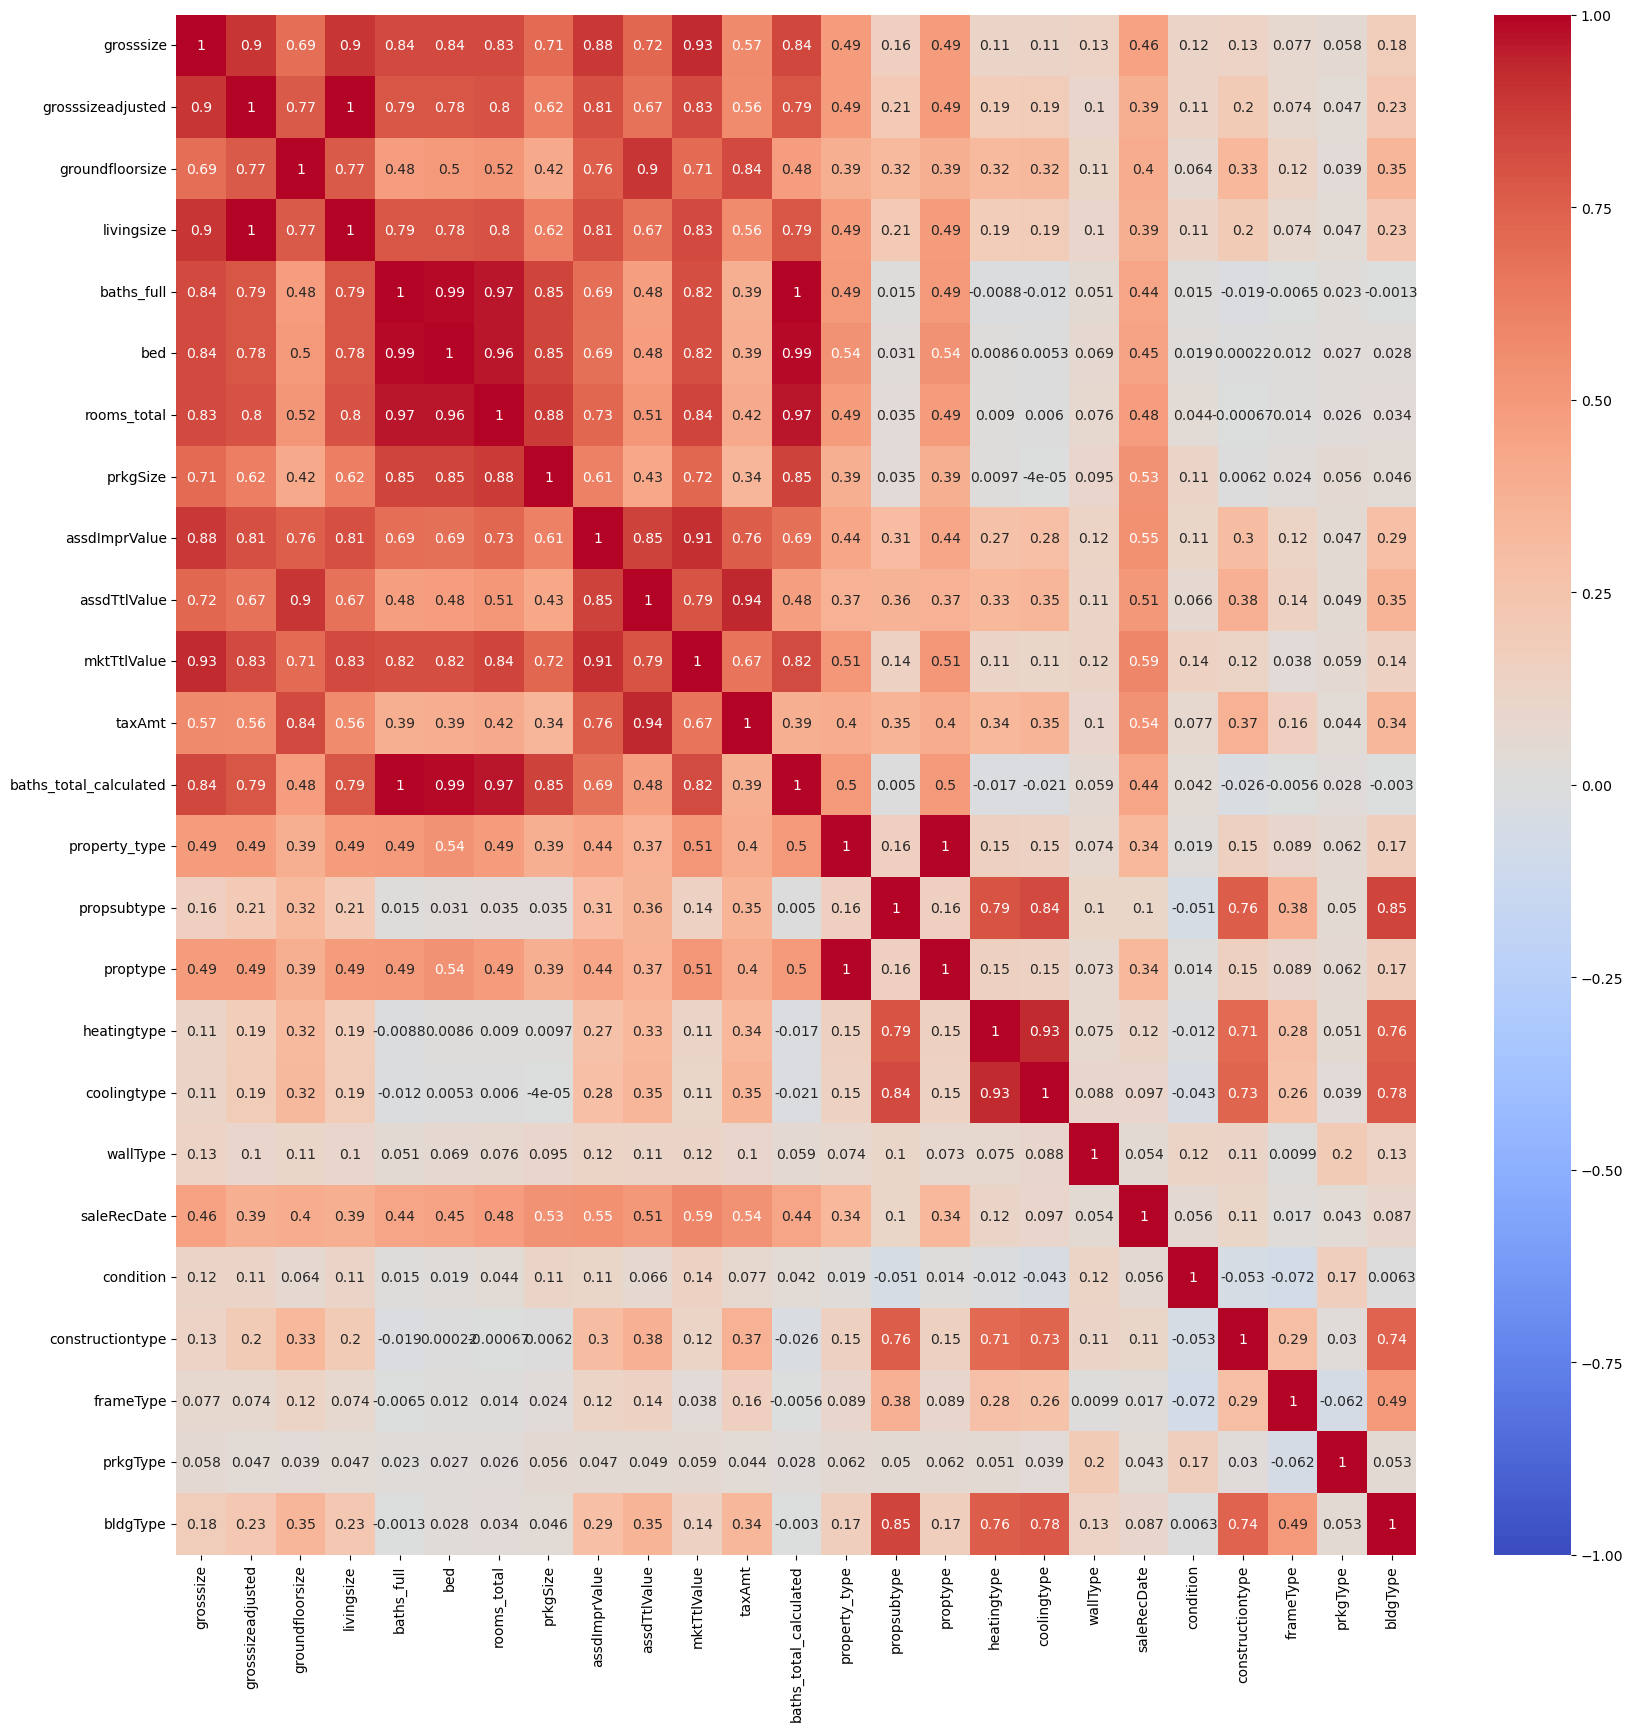

In [53]:
property_df_clust = property_df_normalized.drop("saleAmt", axis=1)

num_cols = property_df_clust.columns[property_df_clust.dtypes != 'object']
# num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df_clust[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

grosssize vs bed, grosssize vs mktTtlValue, taxAmt vs assdTtleValue, livingsize vs rooms_total

In [54]:
property_df_clust.columns

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'property_type', 'propsubtype', 'proptype', 'heatingtype', 'coolingtype', 'wallType', 'saleRecDate', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType'], dtype='object')

In [79]:
# df1 = property_df_clust[['grosssize', 'bed']]
df1 = property_df_clust[['grosssize', 'mktTtlValue']]
# df3 = property_df_clust[['taxAmt', 'assdTtlValue']]
# df4 = property_df_clust[['livingsize', 'rooms_total']]

### Calculate Silhouette Score

Silhouette Scores:
Number of clusters: 2, Silhouette Score: 0.985
Number of clusters: 3, Silhouette Score: 0.97
Number of clusters: 4, Silhouette Score: 0.959
Number of clusters: 5, Silhouette Score: 0.813
Number of clusters: 6, Silhouette Score: 0.661
Number of clusters: 7, Silhouette Score: 0.669
Number of clusters: 8, Silhouette Score: 0.638
Number of clusters: 9, Silhouette Score: 0.532
Number of clusters: 10, Silhouette Score: 0.527


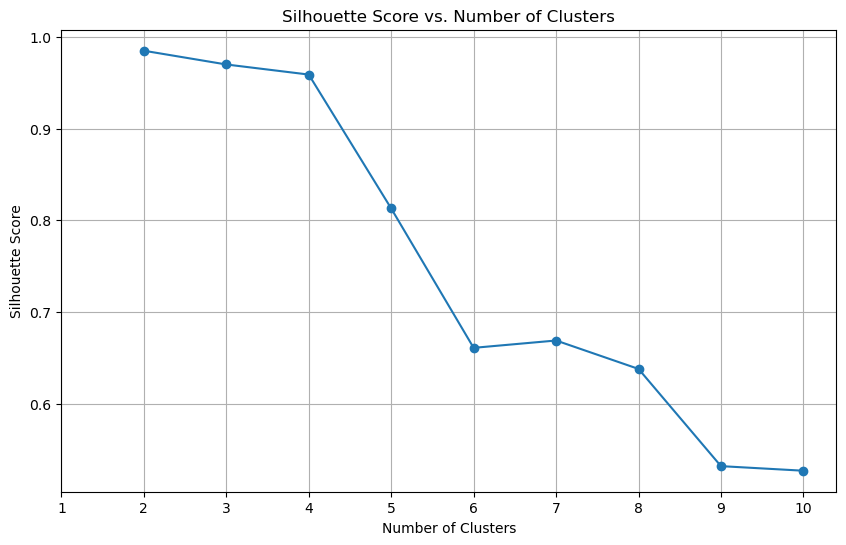

In [80]:
silhouette_scores = []

for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=10)
    preds = clusterer.fit_predict(df1)
    score = silhouette_score(df1, preds)
    silhouette_scores.append([n_clusters, round(score, 3)])

print("Silhouette Scores:")
for score in silhouette_scores:
    print(f"Number of clusters: {score[0]}, Silhouette Score: {score[1]}")


cluster_numbers = [score[0] for score in silhouette_scores]
silhouette_values = [score[1] for score in silhouette_scores]

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, silhouette_values, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

### K Means

For n_clusters = 2 The average silhouette_score is: 0.9848911831380189
For n_clusters = 3 The average silhouette_score is: 0.9695422510740798
For n_clusters = 4 The average silhouette_score is: 0.9591602581928605
For n_clusters = 5 The average silhouette_score is: 0.8134984179027944


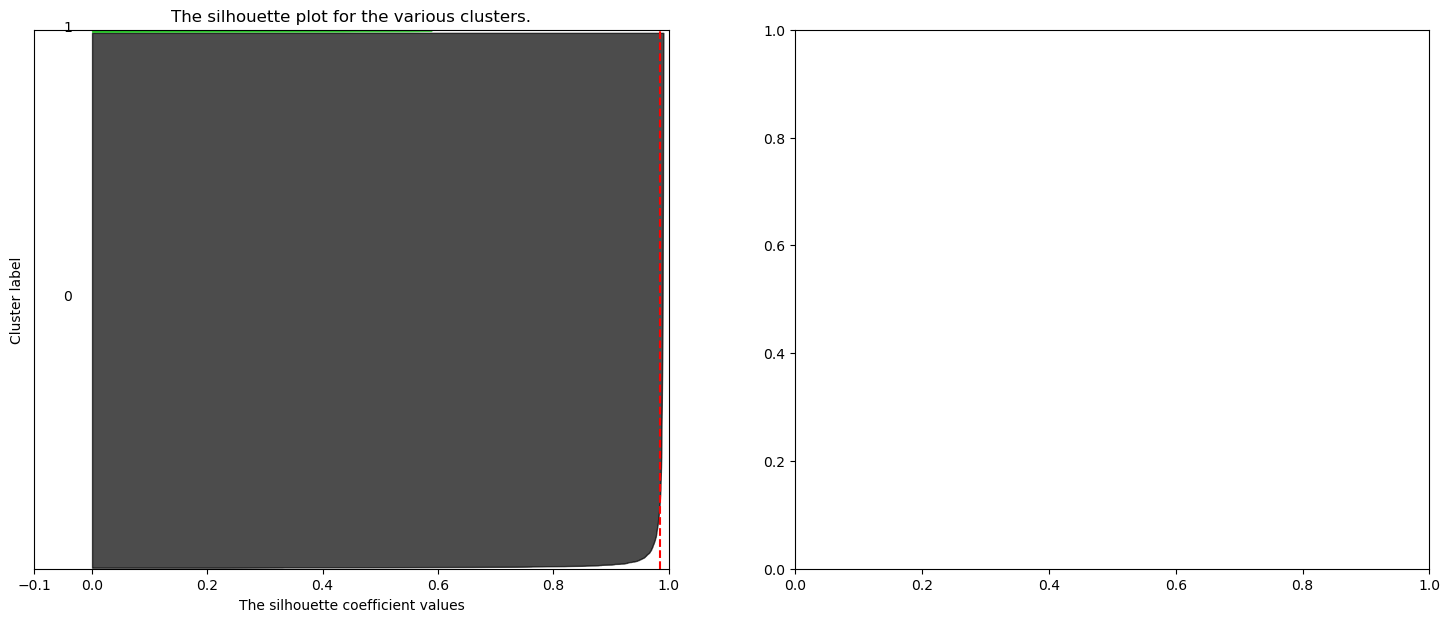

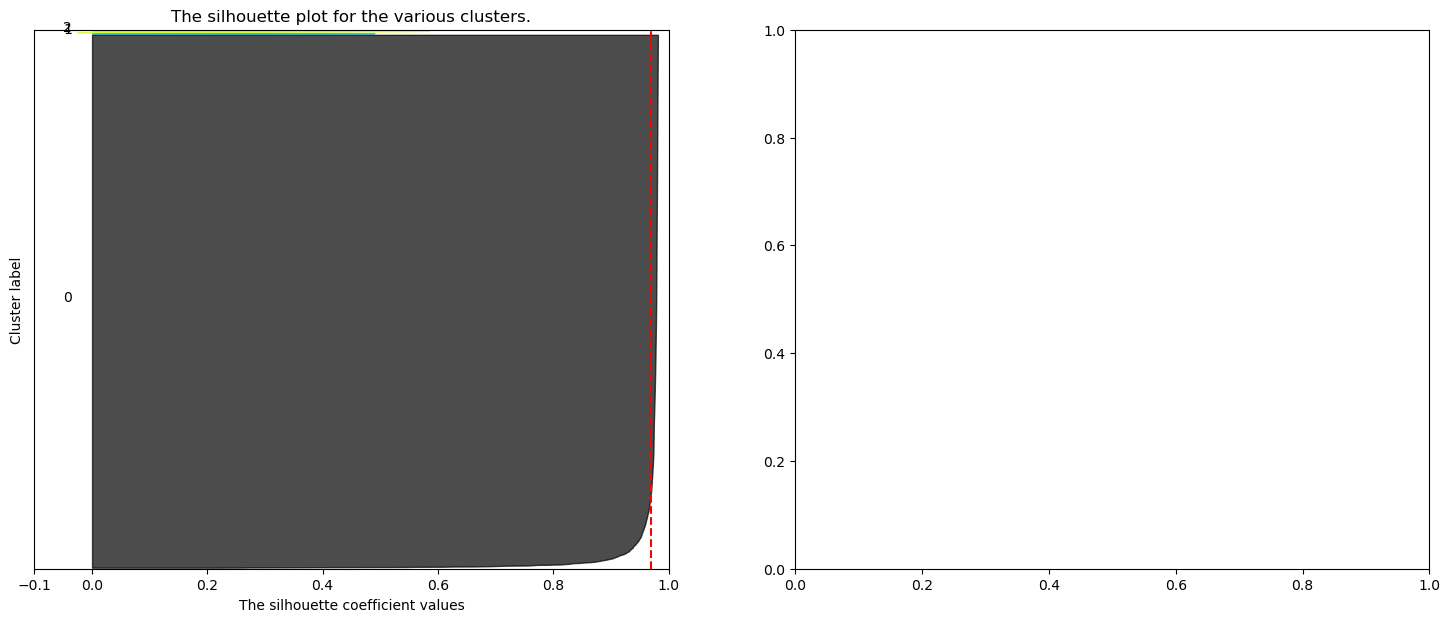

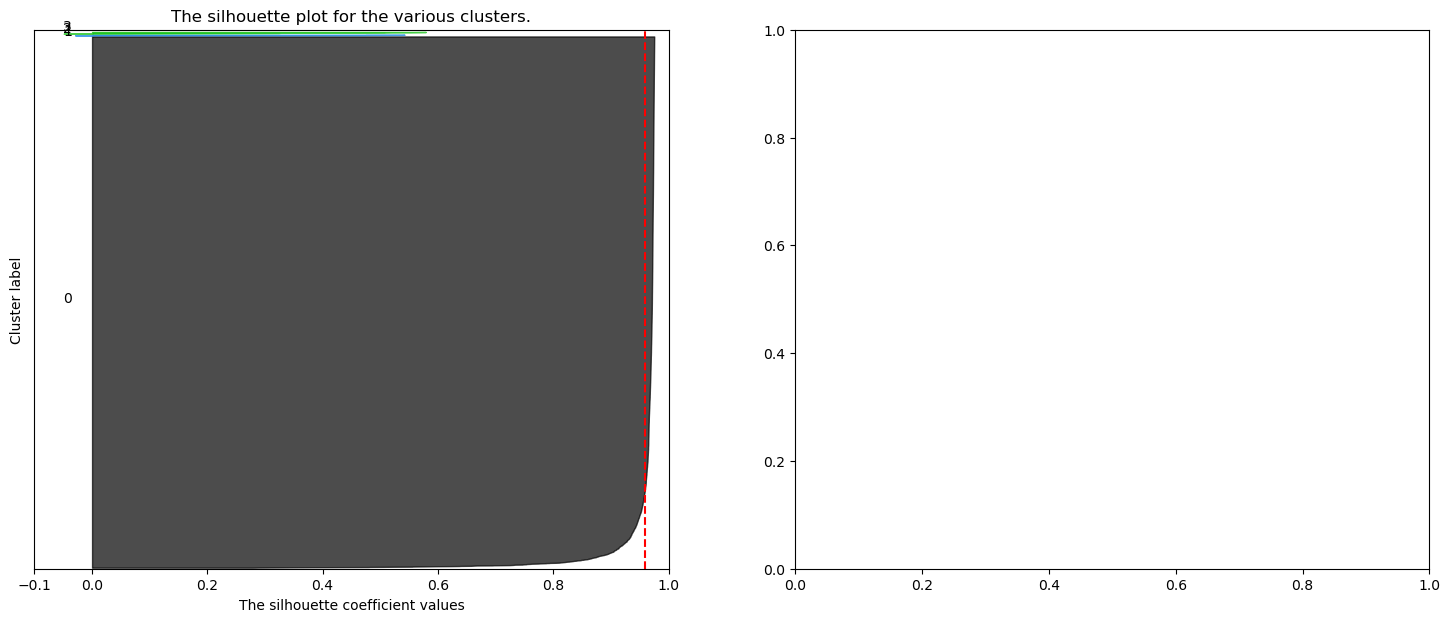

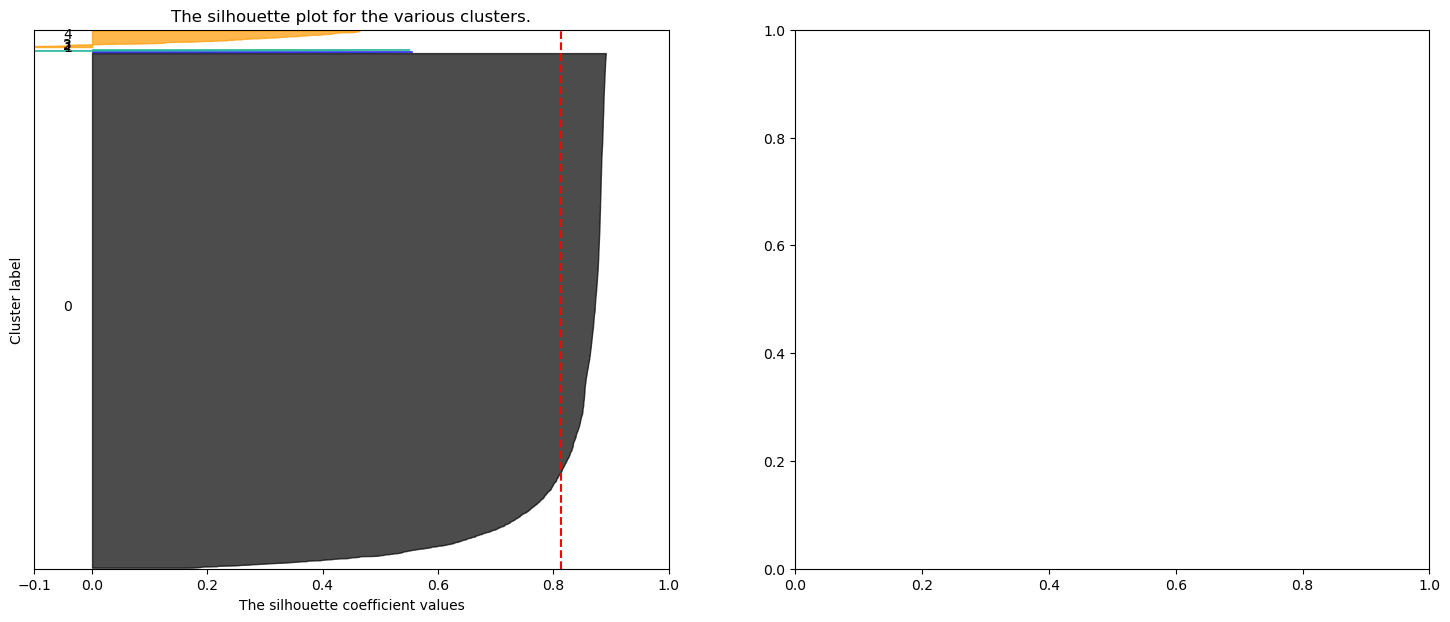

In [81]:
range_n_clusters = [i for i in range(2, 6)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # Set the limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df1)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

C:\Users\Amith Nandivada\AppData\Local\Temp\ipykernel_30260\2908060515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cluster'] = kmeans.labels_


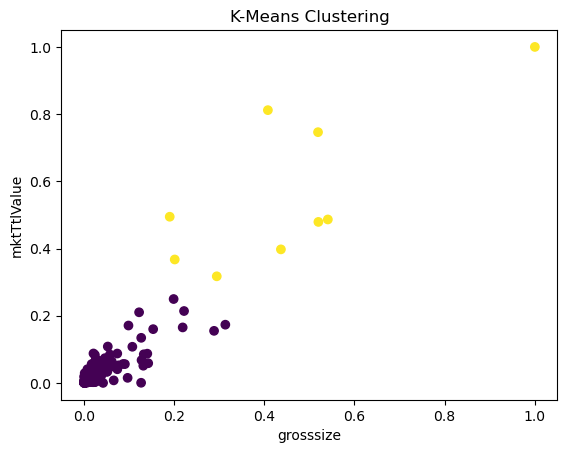

In [82]:
kmeans = KMeans(n_clusters=2).fit(df1)

# Add cluster labels to DataFrame
df1['cluster'] = kmeans.labels_

#Visualize the clusters using a scatter plot
plt.scatter(df1['grosssize'], df1['mktTtlValue'], c=df1['cluster'])
plt.xlabel('grosssize')
plt.ylabel('mktTtlValue')
plt.title('K-Means Clustering')
plt.show()

In [85]:
property_df[['grosssize', 'mktTtlValue']].describe()

,grosssize,mktTtlValue
count,5147.000000,5.147000e+03
mean,2909.412862,8.490291e+05
std,8699.439421,2.115490e+06
min,90.000000,1.300000e+03
25%,1027.500000,4.086000e+05
50%,1938.000000,6.459000e+05
75%,3214.500000,8.931500e+05
max,362967.000000,7.809005e+07


In [88]:
property_df_clust_1 = property_df[['grosssize', 'mktTtlValue']]

In [89]:
property_df_clust_1['mktTtlValue_in_thousands'] = property_df_clust_1['mktTtlValue'] / 1000

C:\Users\Amith Nandivada\AppData\Local\Temp\ipykernel_30260\2665899155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_df_clust_1['mktTtlValue_in_thousands'] = property_df_clust_1['mktTtlValue'] / 1000


In [90]:
property_df_clust_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   grosssize                 5147 non-null   int64  
 1   mktTtlValue               5147 non-null   int64  
 2   mktTtlValue_in_thousands  5147 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 120.8 KB


Silhouette Scores:
Number of clusters: 2, Silhouette Score: 0.986
Number of clusters: 3, Silhouette Score: 0.979
Number of clusters: 4, Silhouette Score: 0.948
Number of clusters: 5, Silhouette Score: 0.773
Number of clusters: 6, Silhouette Score: 0.582
Number of clusters: 7, Silhouette Score: 0.576
Number of clusters: 8, Silhouette Score: 0.576
Number of clusters: 9, Silhouette Score: 0.576
Number of clusters: 10, Silhouette Score: 0.57


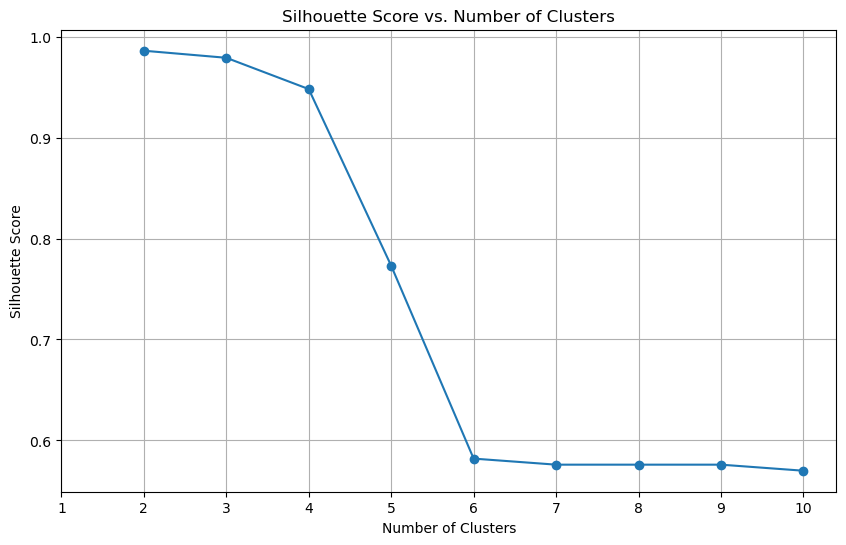

In [91]:
silhouette_scores = []

for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=10)
    preds = clusterer.fit_predict(property_df_clust_1)
    score = silhouette_score(property_df_clust_1, preds)
    silhouette_scores.append([n_clusters, round(score, 3)])

print("Silhouette Scores:")
for score in silhouette_scores:
    print(f"Number of clusters: {score[0]}, Silhouette Score: {score[1]}")


cluster_numbers = [score[0] for score in silhouette_scores]
silhouette_values = [score[1] for score in silhouette_scores]

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, silhouette_values, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

For n_clusters = 2 The average silhouette_score is: 0.986262917004327
For n_clusters = 3 The average silhouette_score is: 0.9789599189615763
For n_clusters = 4 The average silhouette_score is: 0.9481845980677304
For n_clusters = 5 The average silhouette_score is: 0.7733356778798126


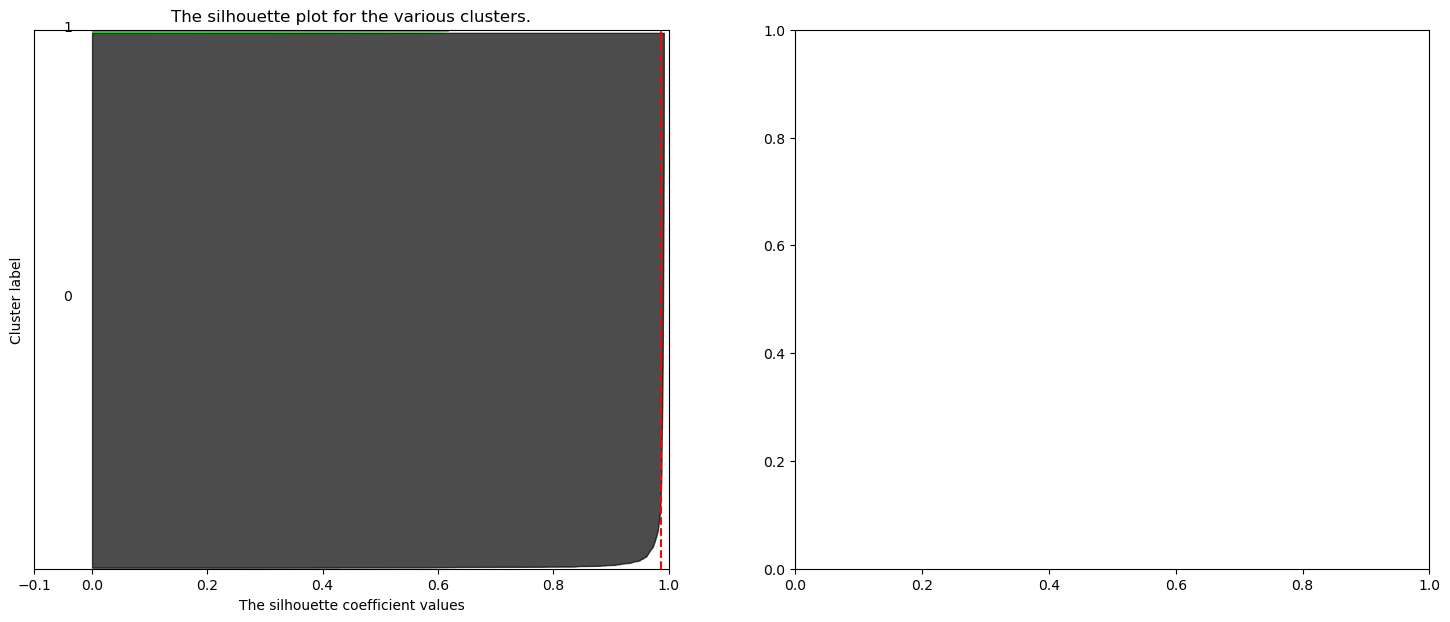

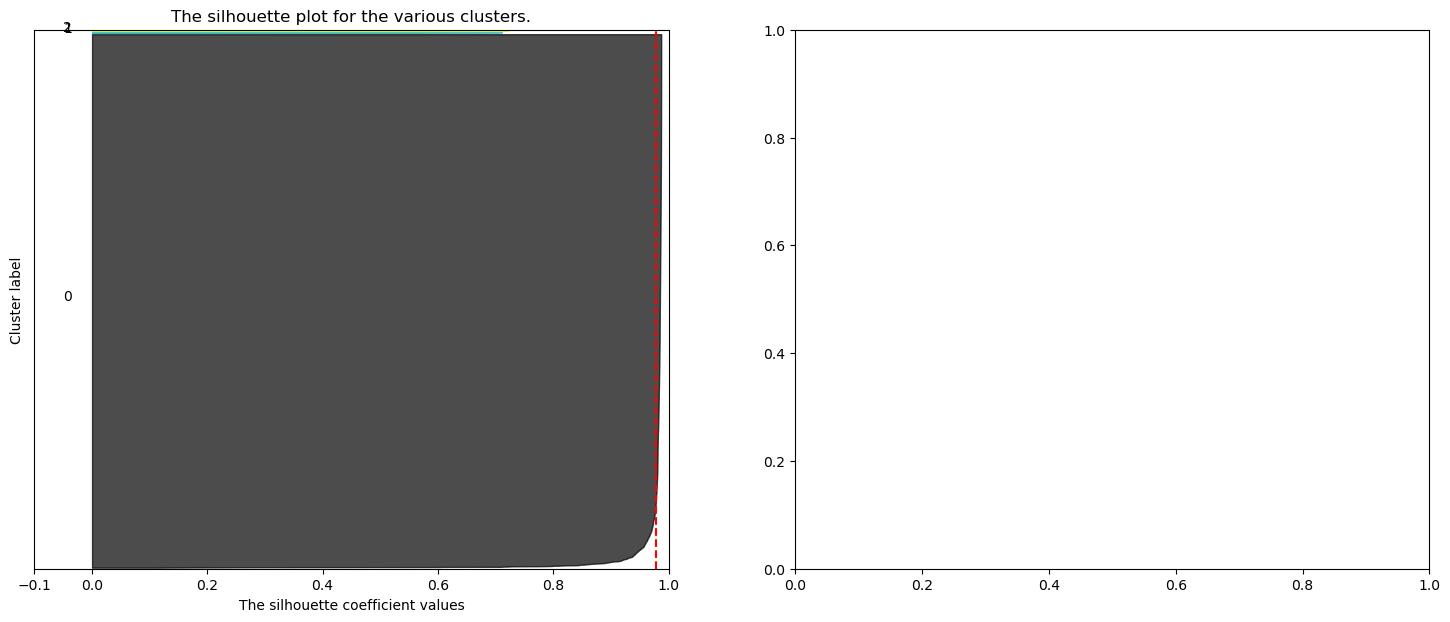

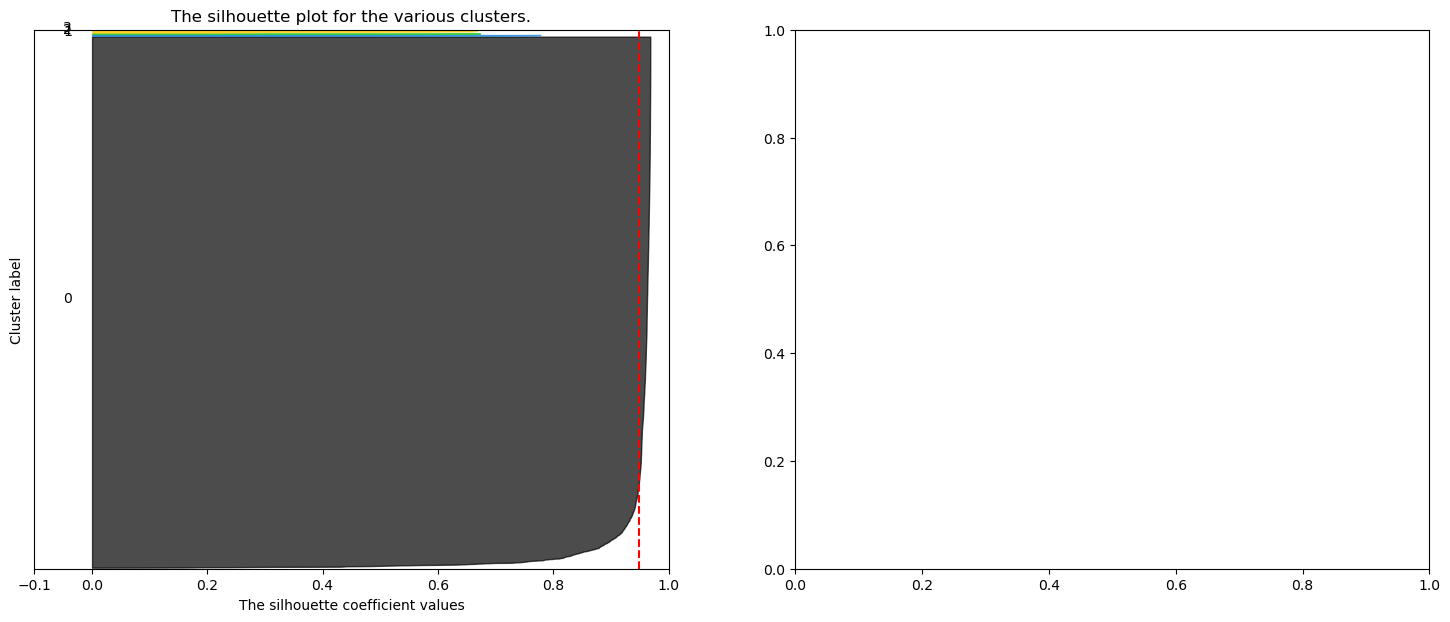

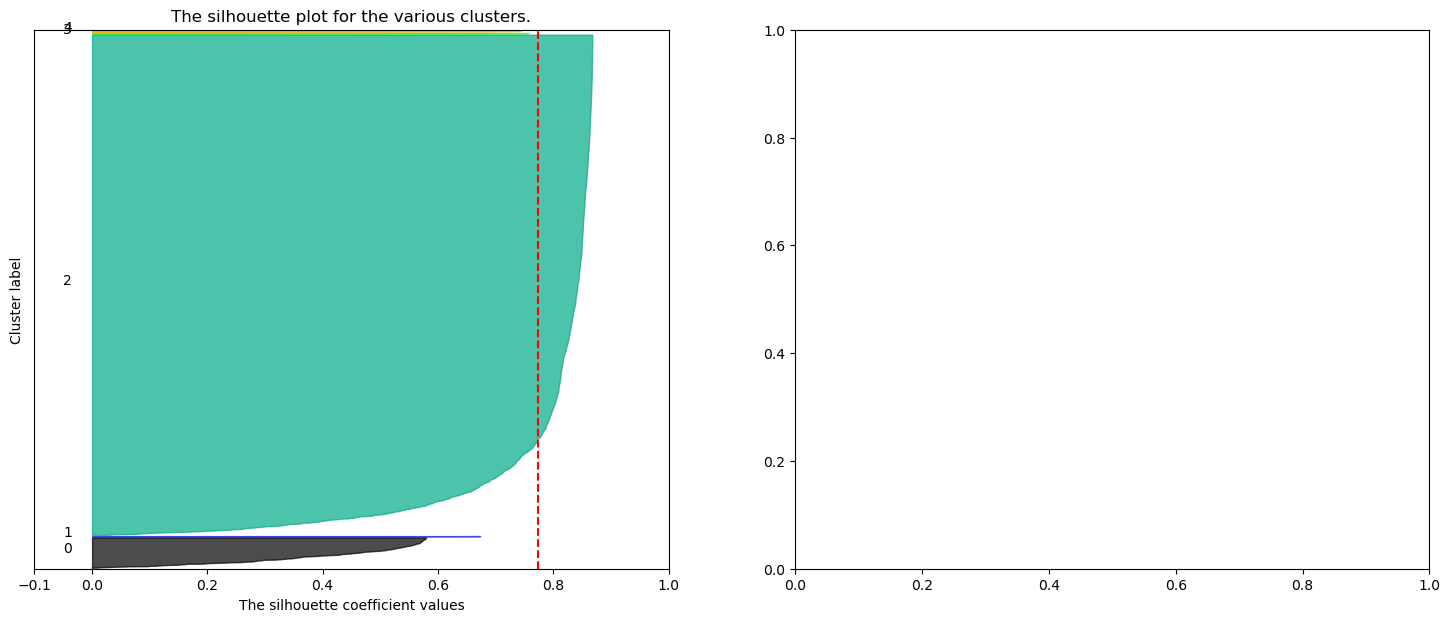

In [92]:
range_n_clusters = [i for i in range(2, 6)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # Set the limits for the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(property_df_clust_1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(property_df_clust_1)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(property_df_clust_1, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(property_df_clust_1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for the average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

C:\Users\Amith Nandivada\AppData\Local\Temp\ipykernel_30260\3819657374.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_df_clust_1[f'cluster_k{k}'] = kmeans.labels_
C:\Users\Amith Nandivada\AppData\Local\Temp\ipykernel_30260\3819657374.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_df_clust_1[f'cluster_k{k}'] = kmeans.labels_
C:\Users\Amith Nandivada\AppData\Local\Temp\ipykernel_30260\3819657374.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

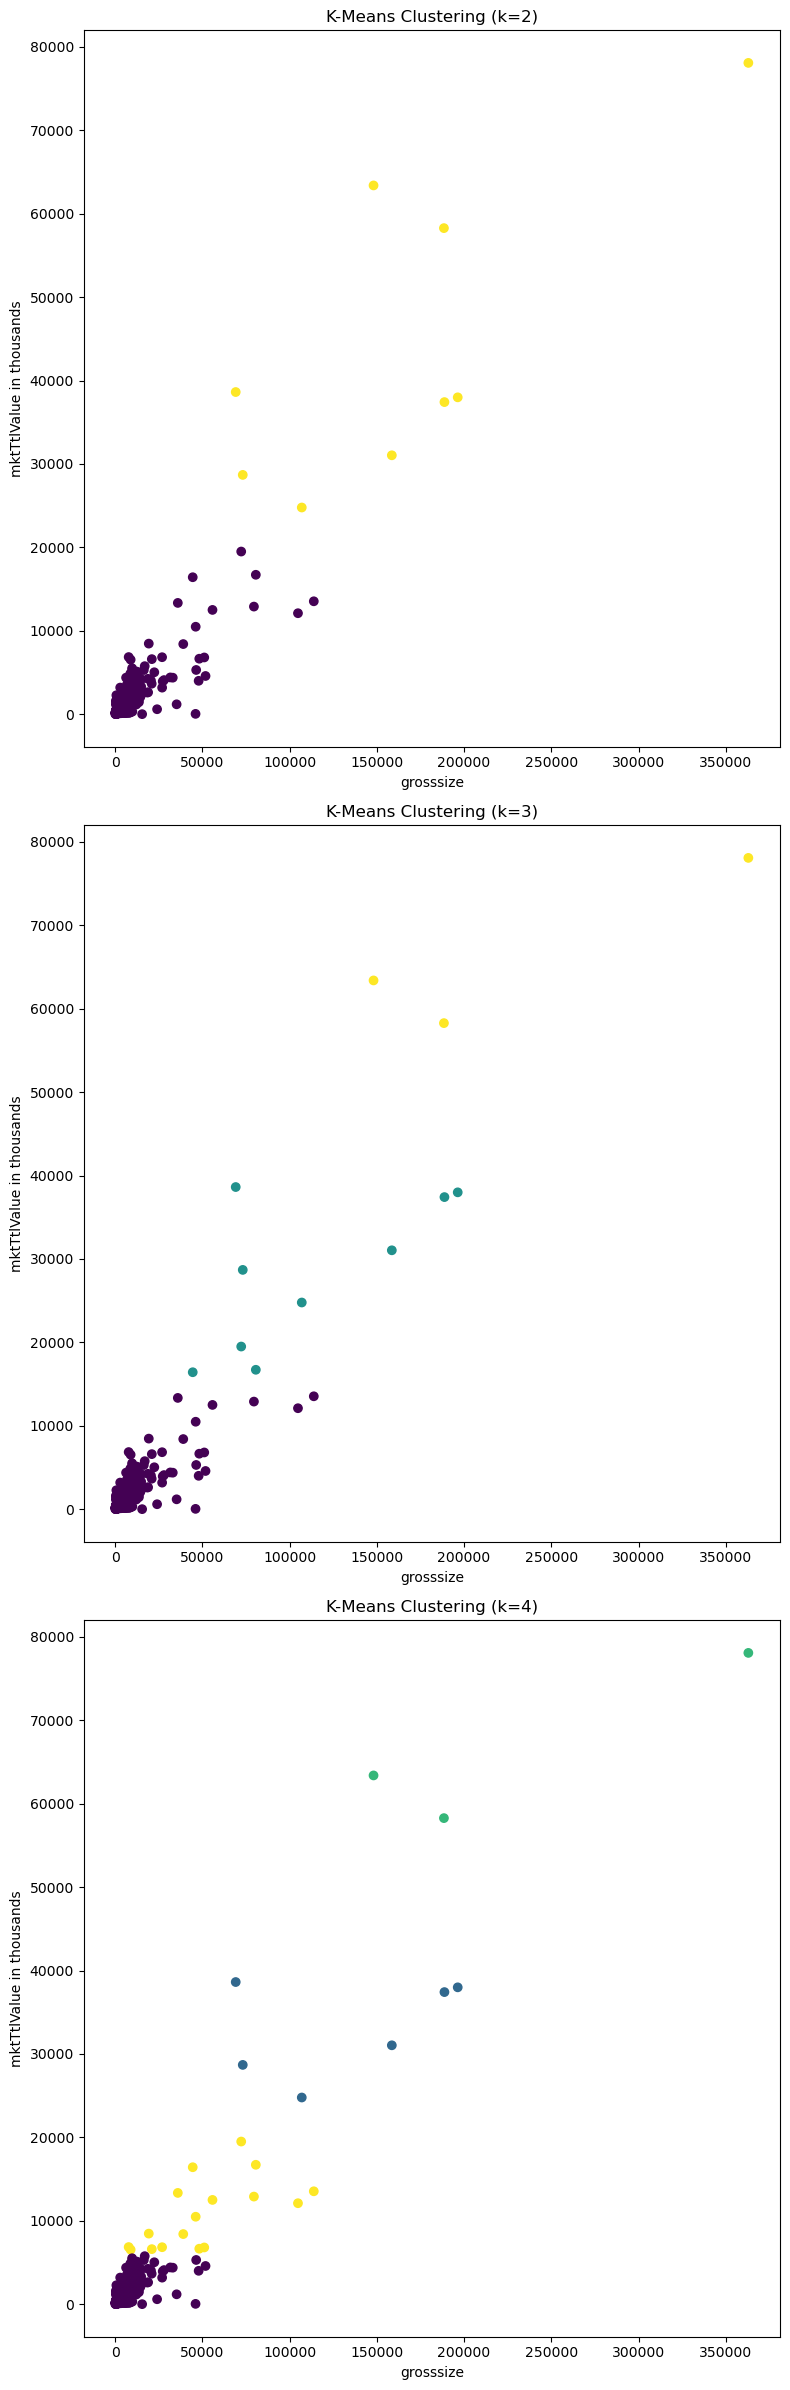

In [101]:
k_values = range(2, 5)
fig, axes = plt.subplots(len(k_values), 1, figsize=(8, 8 * len(k_values)))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(property_df_clust_1)
    
    property_df_clust_1[f'cluster_k{k}'] = kmeans.labels_
    
    # Visualize the clusters using a scatter plot
    axes[i].scatter(property_df_clust_1['grosssize'], property_df_clust_1['mktTtlValue_in_thousands'], c=property_df_clust_1[f'cluster_k{k}'])
    axes[i].set_xlabel('grosssize')
    axes[i].set_ylabel('mktTtlValue in thousands')
    axes[i].set_title(f'K-Means Clustering (k={k})')

plt.tight_layout()
plt.show()

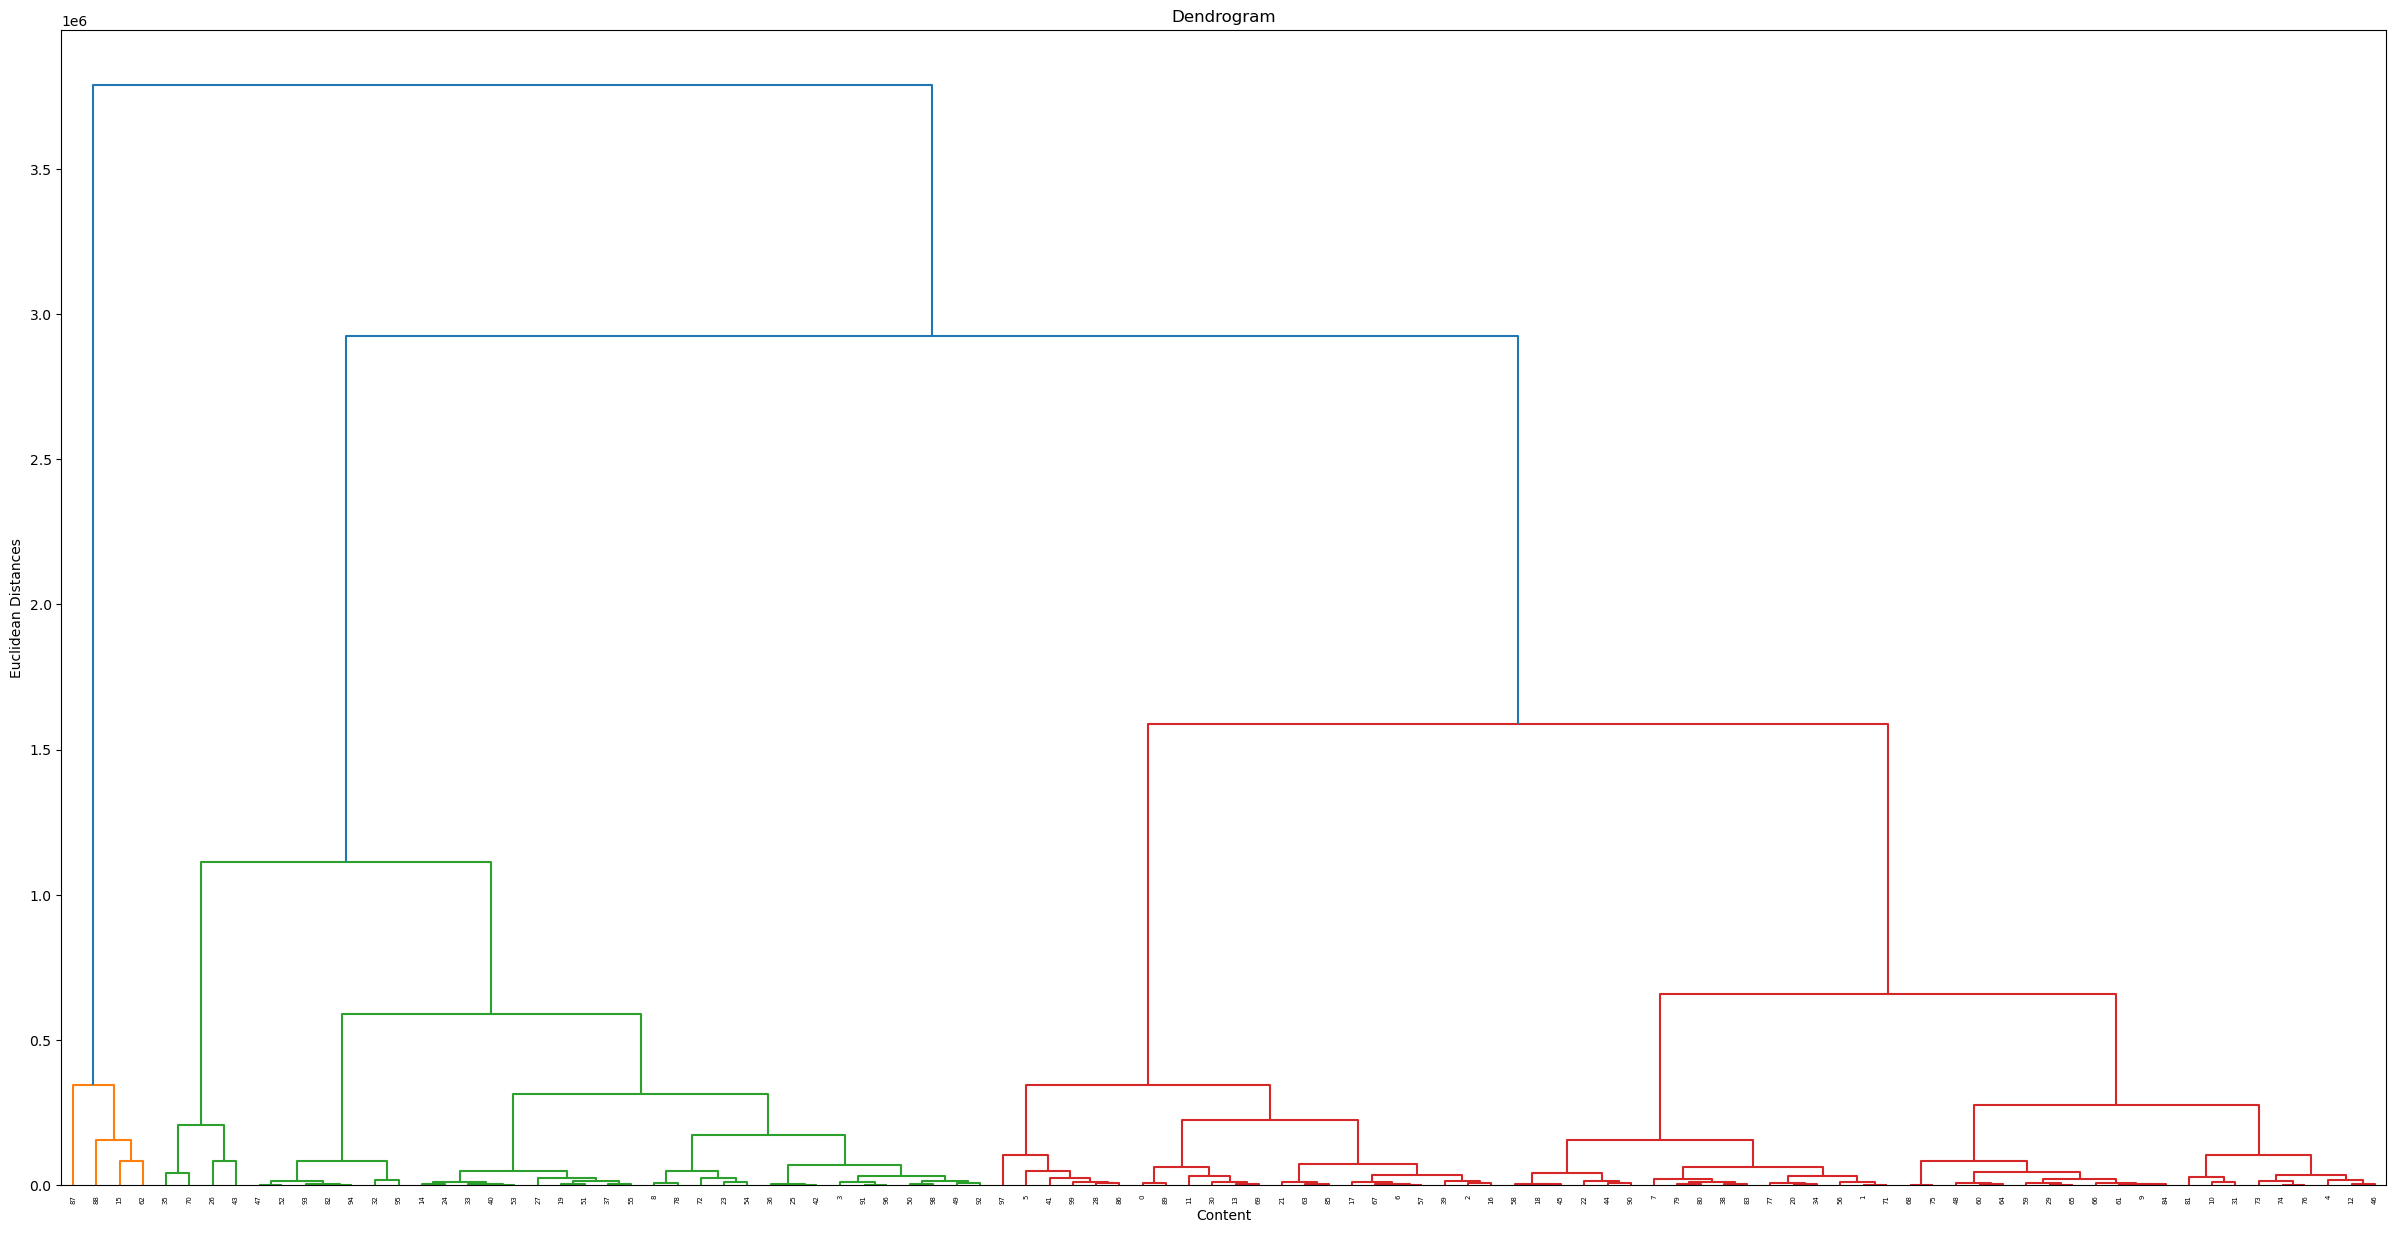

In [103]:
from scipy.cluster.hierarchy import dendrogram, linkage
import random

# Sample 100 random data points
random_indices = random.sample(range(len(property_df_clust_1)), 100)
sampled_data = property_df_clust_1.iloc[random_indices]

# Perform hierarchical clustering
hier_clust = linkage(sampled_data, method='ward', metric='euclidean')

# Create a dendrogram
plt.figure(figsize=(30, 15))
dendrogram(hier_clust, p=2)
plt.title('Dendrogram')
plt.xlabel('Content')
plt.ylabel('Euclidean Distances')
plt.show()